In [1]:
import os
import librosa
import numpy as np
from pydub import AudioSegment
import matplotlib.pyplot as plt
from IPython.display import Audio as disp_audio

from utils import type_DFT
from utils import stft, istft, DFT_Pipeline
from utils import disp_specto, disp_wav, load

In [2]:
SOUND_FILE = "no_role_modelz.wav"
IS_INSTRUMENTAL = False

Make the file in `.wav` format

In [3]:
# check if in mp3 format
if (ext:=SOUND_FILE.split('.')[-1]) in ['mp3', 'flv', 'ogg', 'raw']:

    # convert to wav
    sound = eval(f"AudioSegment.from_{ext}(f'songs/{{SOUND_FILE}}')")
    os.system(f"rm songs/{SOUND_FILE}")
    SOUND_NAME = SOUND_FILE.removesuffix(f'.{ext}')
    sound.export(f"songs/{SOUND_NAME}.wav", format="wav")

else:
    
    # change to just the name of the file
    SOUND_NAME = SOUND_FILE.removesuffix('.wav')

Show segment

In [4]:
song, rate = load(SOUND_NAME, instr=False)

# determine slice for the rest of the thing 
SONG_SLICE = slice(190*rate, 200*rate)

disp_audio(data=song[SONG_SLICE], rate=rate)

Generate instrumental of the track

In [5]:
# credit to https://github.com/tsurumeso/vocal-remover
if IS_INSTRUMENTAL:
    sound = AudioSegment.from_wav(f"songs/{SOUND_NAME}.wav")
    sound.export(f"songs/{SOUND_NAME}_instr.wav", format="wav")
elif f"{SOUND_NAME}_instr.wav" not in os.listdir('songs'):
    _ = os.system(f"./sep_instr.sh {SOUND_NAME}")
song, rate = load(SOUND_NAME)
disp_audio(data=song[SONG_SLICE], rate=rate)

Display waveform of slice

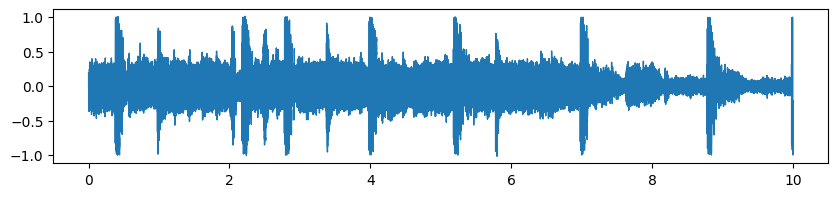

In [6]:
disp_wav(*load(SOUND_NAME), SONG_SLICE)

Display spectograph of slice

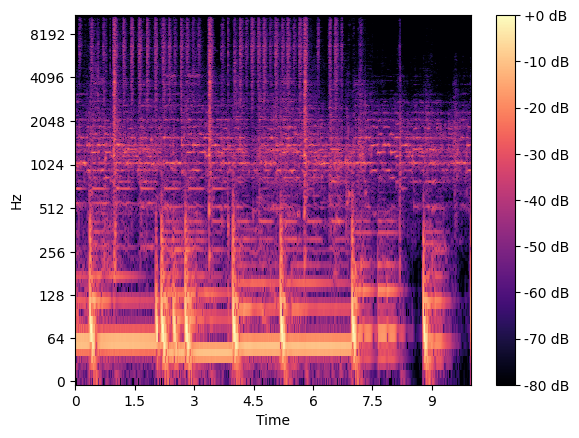

In [7]:
song, _ = load(SOUND_NAME)
s = stft(song[SONG_SLICE])
disp_specto(s)

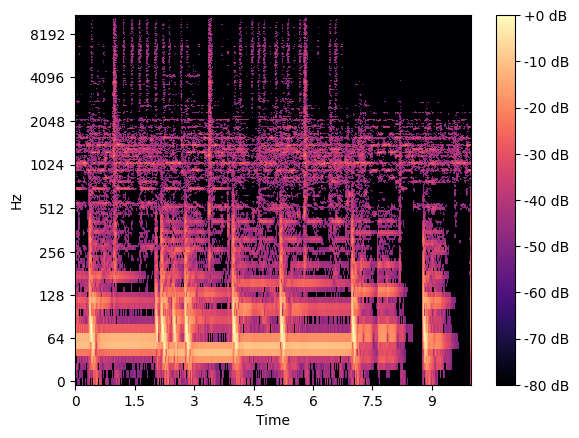

In [19]:
cap = np.vectorize(lambda x: max(0, x))
def remove_weak_freqs(s: type_DFT) -> type_DFT:

    s = np.abs(s)
    
    # compute average of all the frequencies summed up
    avg = np.average(s)

    # calculate mask
    diffs: np.ndarray = cap(s - np.full_like(s, avg))
    mask = diffs.astype(np.bool_).astype(np.uint8)

    # apply mask
    return s * mask

song, rate = load(SOUND_NAME)
s = remove_weak_freqs(stft(song[SONG_SLICE]))
filtered_song = istft(s)
disp_specto(s)
disp_audio(data=filtered_song, rate=rate)

Remove hi-hat and snares

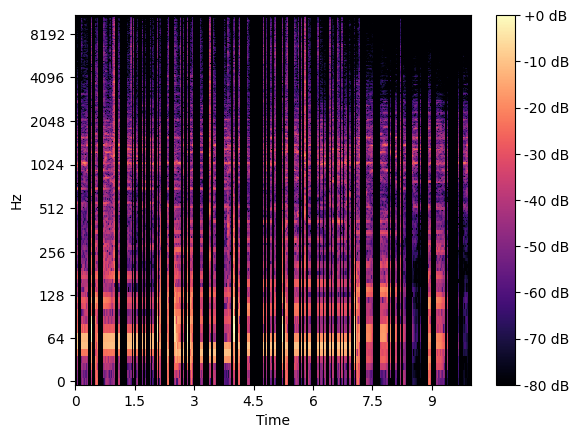

In [22]:
def remove_percussion(s: np.ndarray) -> np.ndarray:
    
    # compute average of all the frequencies summed up
    zipped = np.array([*zip(*[s[i, :] for i in range(s.shape[0])])])
    average_sum = np.average(np.array([np.sum(song[i]) for i in range(zipped.shape[0])]))

    # now do the removing
    for t in range(s.shape[1]):
        if np.sum(s[:, t]) < average_sum:
            s[:, t] = 0   

    return s

song, rate = load(SOUND_NAME)
s = remove_percussion(stft(song[SONG_SLICE]))
disp_specto(s)
disp_audio(istft(s), rate=rate)

Find absolute frequencies

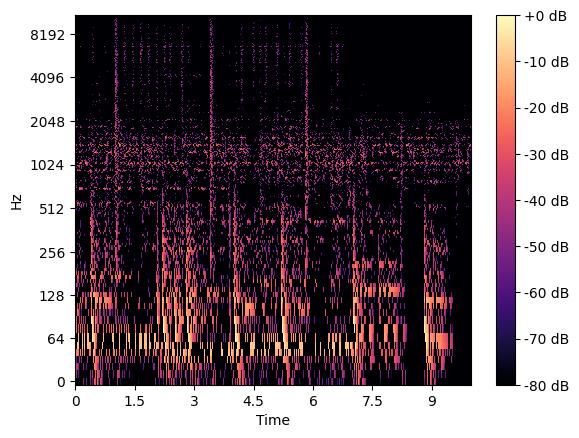

In [23]:
cap = np.vectorize(lambda x: max(0, x))

def sharpen_sounds(s: type_DFT) -> type_DFT:
    s = abs(s)
    new_s = np.zeros_like(s)
    for idx, freq_array in enumerate(s):
        shift_forward = np.array([0, *freq_array])
        shift_back = np.array([*freq_array, 0])
        diff: np.ndarray = cap(shift_forward - shift_back)
        mask = diff.astype(np.bool_).astype(np.uint8)
        new_s[idx] = mask[:-1] * freq_array
    return new_s

song, rate = load(SOUND_NAME)
s = sharpen_sounds(stft(song[SONG_SLICE]))
disp_specto(s)
disp_audio(data=istft(s), rate=rate)

Filter frequencies too high or low

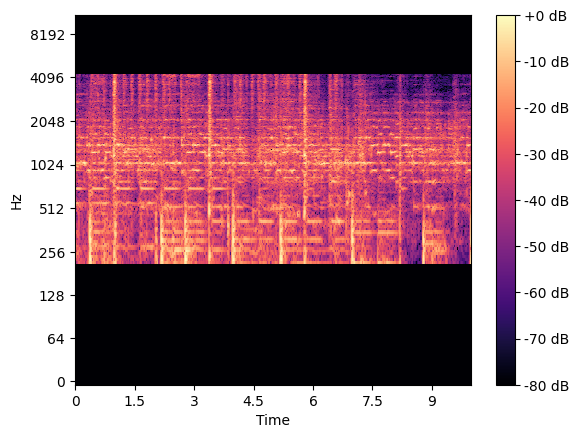

In [25]:
def filter_extreme(s: np.ndarray) -> np.ndarray:
    s[:20] = 0
    s[400:] = 0 
    return s

song, rate = load(SOUND_NAME)
s = filter_extreme(stft(song[SONG_SLICE]))
disp_specto(s)
disp_audio(data=istft(s), rate=rate)

Create pipeline and run the files through

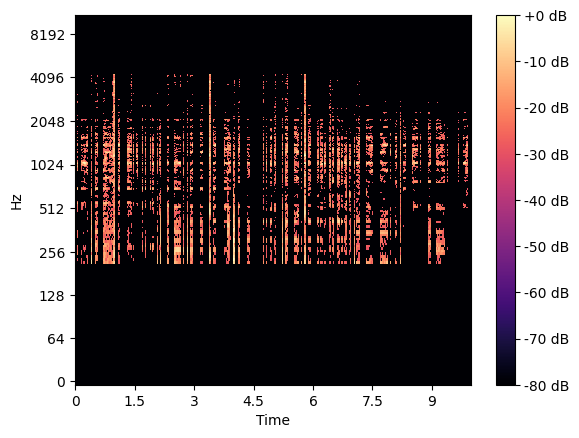

In [27]:
pipeline = DFT_Pipeline(
    remove_percussion, remove_weak_freqs, filter_extreme
)
song, rate = load(SOUND_NAME)
s = pipeline.run(stft(song[SONG_SLICE]))
new_song = istft(s)
disp_specto(s)
disp_audio(new_song, rate=rate)